# ML Pipeline de Operaciones en Flood para Predecir Destruction Level con RandomForestClassifier

## Objetivos

### Predecir Destruction Level (y numérica) a partir de X con features numéricas.

* Borrar columnas, imputar valores faltantes
* Preprocessing:
    * Umbrales a partir de percentiles
    * Función estadística para determinar niveles de Low a Very High a imputar en columna categórica Flood Type.
* Codificación de columna categórica con OrdinalEncoder: Flood Type a Destruction Level de ranking numérico (1-4).
* Pipeline para agrupar múltiples operaciones en un mismo objeto::
    + Imputar most_frequent a nulos con SimpleImputer
    + Escalar características numéricas con MinMaxScaler
    + Modelo usado a partir de validación: RandomForestClassifier
* SMOTE
* Predicción de Destruction Level
* Comparación y validación de resultados de Test A controlado, B outliers, C low  y D Xreducido

## Importar librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split X train y test
from sklearn.model_selection import train_test_split

# Imputador para columnas de Totales de Impacto


# Modelos para validación cruzada con cross_val_score y cross_validate
from sklearn.ensemble import RandomForestClassifier # Elegido
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelos para validar por regresión
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

# Validación de modelos:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Calificación de modelos
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import SCORERS

# Para imputación categórica a numérica y predicción de columna numérica Destruction Level en Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

# Pipeline
from sklearn.pipeline import Pipeline
import joblib # guardar pipeline

In [2]:
# Display all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

## Cargar datos

In [3]:
df = pd.read_csv('../../../Data/03Limpio/03desastreslimpio.csv')
df.head(10)

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,ISO,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Latitude,Longitude,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
0,1900-9002-CPV,1900,9002,Climatological,Drought,Drought,Cabo Verde,CPV,Western Africa,Africa,Countrywide,NaN,Famine,0,Km2,NaN,NaN,1900,0,0,1900,0,0,11000,0,0
1,1900-9001-IND,1900,9001,Climatological,Drought,Drought,India,IND,Southern Asia,Asia,Bengal,NaN,NaN,0,Km2,NaN,NaN,1900,0,0,1900,0,0,1250000,0,0
2,1902-0012-GTM,1902,12,Geophysical,Earthquake,Ground movement,Guatemala,GTM,Central America,Americas,"Quezaltenango, San Marcos",NaN,Tsunami/Tidal wave,8,Richter,14,-91,1902,4,18,1902,4,18,2000,0,843726
3,1902-0003-GTM,1902,3,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,NaN,NaN,NaN,0,NaN,NaN,NaN,1902,4,8,1902,4,8,1000,0,0
4,1902-0010-GTM,1902,10,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,NaN,NaN,NaN,0,NaN,NaN,NaN,1902,10,24,1902,10,24,6000,0,0
5,1903-0006-CAN,1903,6,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,"Frank, Alberta",NaN,NaN,0,NaN,NaN,NaN,1903,4,29,1903,4,29,76,23,0
6,1903-0012-COM,1903,12,Geophysical,Volcanic activity,Ash fall,Comoros (the),COM,Eastern Africa,Africa,NaN,NaN,NaN,0,NaN,NaN,NaN,1903,0,0,1903,0,0,17,0,0
7,1904-0003-BGD,1904,3,Meteorological,Storm,Tropical cyclone,Bangladesh,BGD,Southern Asia,Asia,Chittagong,NaN,NaN,0,Kph,NaN,NaN,1904,11,0,1904,11,0,0,0,0
8,1905-0005-CAN,1905,5,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,"Spence's Bridge, British Columbia",NaN,NaN,0,NaN,NaN,NaN,1905,8,13,1905,8,13,18,18,0
9,1905-0003-IND,1905,3,Geophysical,Earthquake,Ground movement,India,IND,Southern Asia,Asia,Kangra,NaN,NaN,8,Richter,32.04,76.16,1905,4,4,1905,4,4,20000,0,812477


## Comprobación Básica df

In [4]:
df.shape

(16636, 26)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16636 entries, 0 to 16635
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Dis No             16636 non-null  object
 1   Year               16636 non-null  int64 
 2   Seq                16636 non-null  int64 
 3   Disaster Subgroup  16636 non-null  object
 4   Disaster Type      16636 non-null  object
 5   Disaster Subtype   13313 non-null  object
 6   Country            16636 non-null  object
 7   ISO                16636 non-null  object
 8   Region             16636 non-null  object
 9   Continent          16636 non-null  object
 10  Location           14825 non-null  object
 11  Origin             4085 non-null   object
 12  Associated Dis     3593 non-null   object
 13  Dis Mag Value      16636 non-null  int64 
 14  Dis Mag Scale      15416 non-null  object
 15  Latitude           2775 non-null   object
 16  Longitude          2775 non-null   objec

In [6]:
df.columns

Index(['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Dis Mag Value', 'Dis Mag Scale',
       'Latitude', 'Longitude', 'Start Year', 'Start Month', 'Start Day',
       'End Year', 'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj'],
      dtype='object')

In [7]:
print(df.isnull().sum())
print(df.isna().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64
Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location       

# Preparación de dataset

## Filtro Flood

In [8]:
# Filtro principal para Flood
df_flood = df[df['Disaster Type'] == 'Flood']

### Limpieza

In [9]:
df_flood['Dis Mag Scale'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_flood[['Dis Mag Scale']])
df_flood['Dis Mag Scale'].isnull().sum()

C:\Users\AleEng\AppData\Local\Temp\ipykernel_760\2513547182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Dis Mag Scale'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_flood[['Dis Mag Scale']])


0

In [10]:
df_flood['Disaster Subtype'] = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown').fit_transform(df_flood[['Disaster Subtype']])
df_flood['Disaster Subtype'].isnull().sum()
df_flood['Disaster Subtype'].unique()

C:\Users\AleEng\AppData\Local\Temp\ipykernel_760\2586547590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Disaster Subtype'] = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown').fit_transform(df_flood[['Disaster Subtype']])


array(['Unknown', 'Riverine flood', 'Coastal flood', 'Flash flood'],
      dtype=object)

### Valores faltantes

#### Borrar columnas

In [11]:
df_flood.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Latitude', 'Longitude', 'ISO'], inplace=True)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_760\2601801454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Latitude', 'Longitude', 'ISO'], inplace=True)


In [12]:
df_flood.head(2)

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
12,Flood,Unknown,Belgium,Western Europe,Europe,Louvain region,NaN,NaN,0,Km2,1906,5,14,1906,5,14,6,0,0
13,Flood,Unknown,Belgium,Western Europe,Europe,NaN,NaN,NaN,0,Km2,1906,4,0,1906,4,0,0,0,0


In [13]:
print(df.isnull().sum())
print(df.isna().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64
Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location       

# Preprocessing

## Preprocessing 1: crear columna categórica Flood Type y codificar columna numérica Destruction Level con OneHotEncoder para predecir y

#### Filtro para excluir filas con valores 0 en 'Dis Mag Value', 'Total Deaths', 'Total Affected' y 'Total Damages Adj'

In [14]:
# df_flood = df[(df['Dis Mag Value'] > 0) & 
#                  (df['Total Deaths'] > 0) & 
#                  (df['Total Affected'] > 0) & 
#                  (df['Total Damages Adj'] > 0)]

In [15]:
df_flood['Dis Mag Value'].min()

0

In [16]:
df_flood.shape

(5808, 19)

### Condiciones estadísticas para determinar umbrales de clasificación para Tipo de Inundación y su Nivel de Destrucción

In [17]:
min_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].min()
max_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].max()
std_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].std()
mean_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].mean()
median_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].median()

min_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].min()
max_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].max()
std_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].std()
mean_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].mean()
median_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].median()

min_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].min()
max_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].max()
std_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].std()
mean_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].mean()
median_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].median()

min_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].min()
max_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].max()
std_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].std()
mean_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].mean()
median_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].median()

.loc[df_flood['Dis Mag Value'].gt(0)]: El método .loc se usa para acceder a filas específicas del DataFrame según una condición. En este caso, la condición es df_flood['Dis Mag Value'].gt(0), que verifica si los valores en la columna 'Dis Mag Value' son mayores que 0. Esta condición crea una máscara booleana, donde cada elemento en el DataFrame se reemplaza con True si es mayor que 0 y False en caso contrario.

In [18]:
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].min())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].max())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].std())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].mean())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].median())

print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].min())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].max())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].std())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].mean())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].median())

print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].min())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].max())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].std())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].mean())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].median())

print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].min())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].max())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].std())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].mean())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].median())

2
2857000
206861.50686270732
92063.0765334834
24681.0
1
3700000
65196.51587469585
1656.5946073793757
16.0
2
238973000
7561334.5755781615
811324.9760785116
11000.0
5
53860097
3156399.414884343
861012.3965244866
87845.0


### Análisis de  Dis Mag Value

Dis Mag Value determina el impacto de la extensión de las inundaciones, por tanto, es la variable numérica principal para X

#### Value counts de 'Dis Mag Value'

In [19]:
df_flood['Dis Mag Value'].value_counts()

0          4031
100           8
200           7
3000          7
550           6
10            6
1000          6
60            6
300           5
150           5
1200          5
400           5
8000          4
70            4
4900          4
500           4
600           4
35            3
17000         3
9             3
108           3
5300          3
1100          3
850           3
4600          3
1400          3
20            3
630           3
560           3
290           3
18            3
22760         3
4             3
2500          3
55860         3
10000         3
110           3
700           3
80            3
2000          3
11140         2
4050          2
4630          2
730           2
190           2
390           2
1980          2
19200         2
7700          2
250           2
18940         2
37320         2
5180          2
1170          2
180760        2
960           2
20490         2
14990         2
4200          2
12680         2
44620         2
32700         2
350     

In [20]:
print(df_flood['Dis Mag Value'].unique())

[     0   3000 150000 ...  33791  18949   4232]


In [21]:
# value counts de cada valor único en orden descendiente
print(df_flood['Dis Mag Value'].value_counts().sort_index(ascending=False))

2857000       1
2643786       1
2440002       1
1834048       1
1829701       1
1668000       1
1591000       1
1341347       1
1330000       1
1287000       1
1232000       1
1217000       1
1215862       1
1186000       1
1164000       1
1140146       1
1120000       1
1037639       1
1015000       1
955800        1
911256        1
849465        1
840000        1
832001        1
812700        1
810942        1
801000        1
776608        1
762900        1
761154        1
720844        1
689100        1
678500        1
649500        1
645400        1
634200        1
632316        1
630100        1
629962        1
629242        1
625200        1
624200        1
619200        1
619100        1
614000        1
587384        1
585146        1
582300        1
578300        1
577783        1
574057        1
571700        1
565200        1
554200        1
545400        1
544053        1
542100        1
538000        1
524900        1
524400        1
518000        1
507800        1
493137  

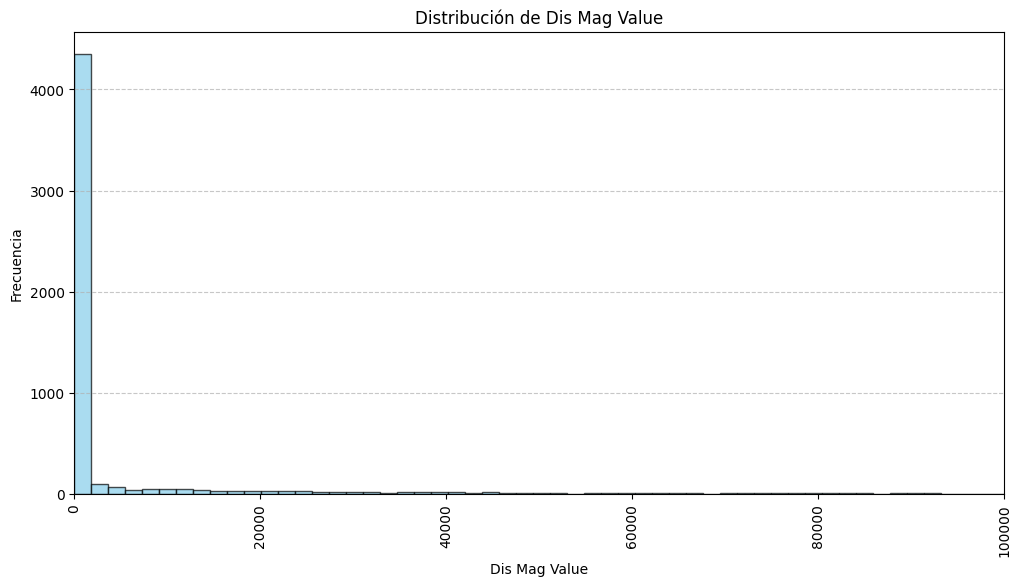

In [22]:
# value counts y sort by index
value_counts_sorted = df_flood['Dis Mag Value'].value_counts().sort_index()

# Histograma
plt.figure(figsize=(12, 6))
plt.hist(df_flood['Dis Mag Value'], bins=len(value_counts_sorted), edgecolor='black', color='skyblue', alpha=0.7)
plt.xlabel('Dis Mag Value')
plt.ylabel('Frecuencia')
plt.title('Distribución de Dis Mag Value')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# x-axis limits para zoom
plt.xlim(0, 100000)

plt.show()

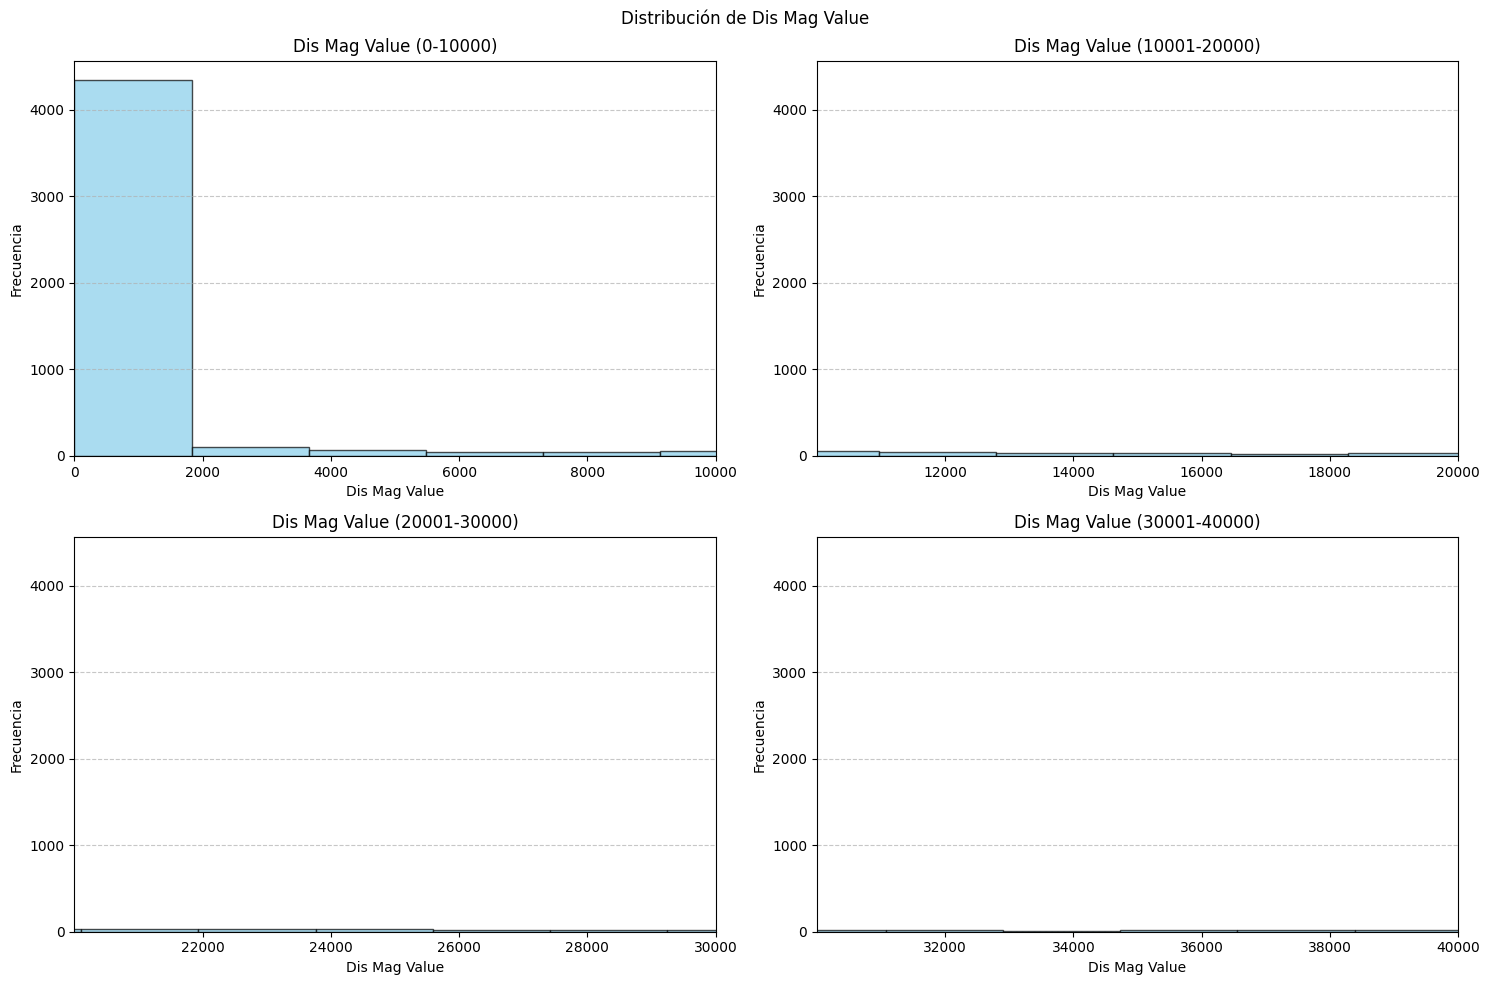

In [23]:
# Value counts y sort by index
value_counts_sorted = df_flood['Dis Mag Value'].value_counts().sort_index()

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Distribución de Dis Mag Value')

# Rangos de zoom para cada subplot
zoom_ranges = [(0, 10000), (10001, 20000), (20001, 30000), (30001, 40000), (40001, 50000)]

# Sector segmentado por zoom
for i, ax in enumerate(axes.flat):
    lower_limit, upper_limit = zoom_ranges[i]
    ax.hist(df_flood['Dis Mag Value'], bins=len(value_counts_sorted), edgecolor='black', color='skyblue', alpha=0.7)
    ax.set_xlabel('Dis Mag Value')
    ax.set_ylabel('Frecuencia')
    ax.set_xlim(lower_limit, upper_limit)
    ax.set_title(f'Dis Mag Value ({lower_limit}-{upper_limit})')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Filtro para eliminar los valores de magnitud 0 de df_flood, resultado: df_filtered

In [24]:
filter = df_flood['Dis Mag Value'] != 0
df_flood_filtered = df_flood[filter]
df_flood_filtered.head()

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
39,Flood,Riverine flood,China,Eastern Asia,Asia,Guangzhou,NaN,NaN,3000,Km2,1915,0,0,1915,0,0,0,3000000,0
123,Flood,Unknown,China,Eastern Asia,Asia,NaN,NaN,NaN,150000,Km2,1935,0,0,1935,0,0,142000,10030000,0
630,Flood,Unknown,Algeria,Northern Africa,Africa,"Northeast, Tlemcen",NaN,NaN,770,Km2,1973,3,0,1973,3,0,21,146000,65913
632,Flood,Unknown,Ecuador,South America,Americas,NaN,NaN,NaN,15000,Km2,1973,2,0,1973,2,0,0,30000,0
782,Flood,Unknown,Ethiopia,Eastern Africa,Africa,Awash River Valley,NaN,NaN,18,Km2,1977,11,0,1977,11,0,7,16000,0


## Umbrales con percentiles

In [25]:
# mask = df_flood['Dis Mag Value'] != 0 # filtro anterior mejor que máscara

# Calcular percentiles 25, 50 y 75 para Dis Mag Value, excluyendo 0

type1_threshold = np.percentile(df_flood_filtered['Dis Mag Value'], 25)
type2_threshold = np.percentile(df_flood_filtered['Dis Mag Value'], 50)
type3_threshold = np.percentile(df_flood_filtered['Dis Mag Value'], 75)

print(f'Umbral 1: {type1_threshold}')
print(f'Umbral 2: {type2_threshold}')
print(f'Umbral 3: {type3_threshold}')

Umbral 1: 4210.0
Umbral 2: 24681.0
Umbral 3: 84762.0


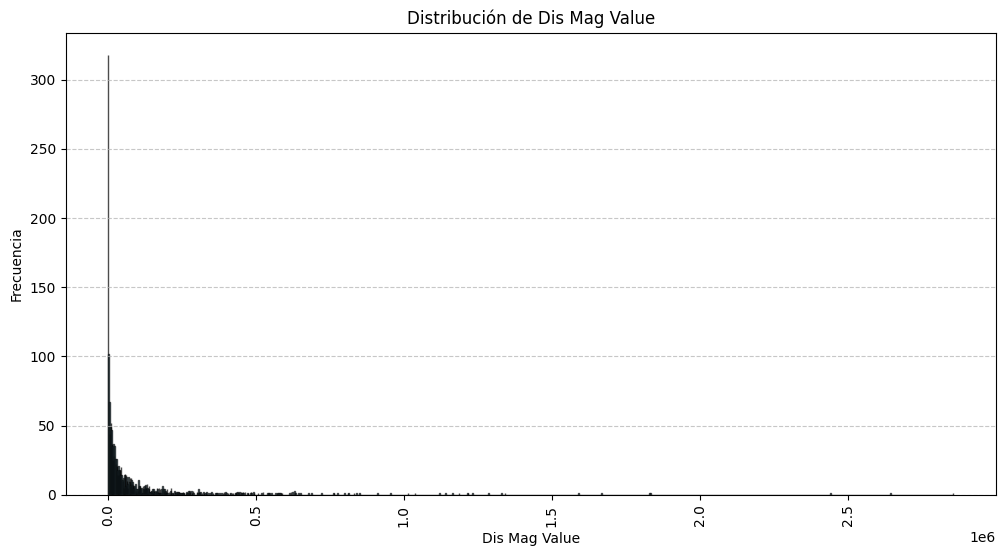

In [26]:
# value counts y sort by index
value_counts_sorted = df_flood_filtered['Dis Mag Value'].value_counts().sort_index()

# Histograma
plt.figure(figsize=(12, 6))
plt.hist(df_flood_filtered['Dis Mag Value'], bins=len(value_counts_sorted), edgecolor='black', color='skyblue', alpha=0.7)
plt.xlabel('Dis Mag Value')
plt.ylabel('Frecuencia')
plt.title('Distribución de Dis Mag Value')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# x-axis limits para zoom
# plt.xlim(0, 100000)

plt.show()

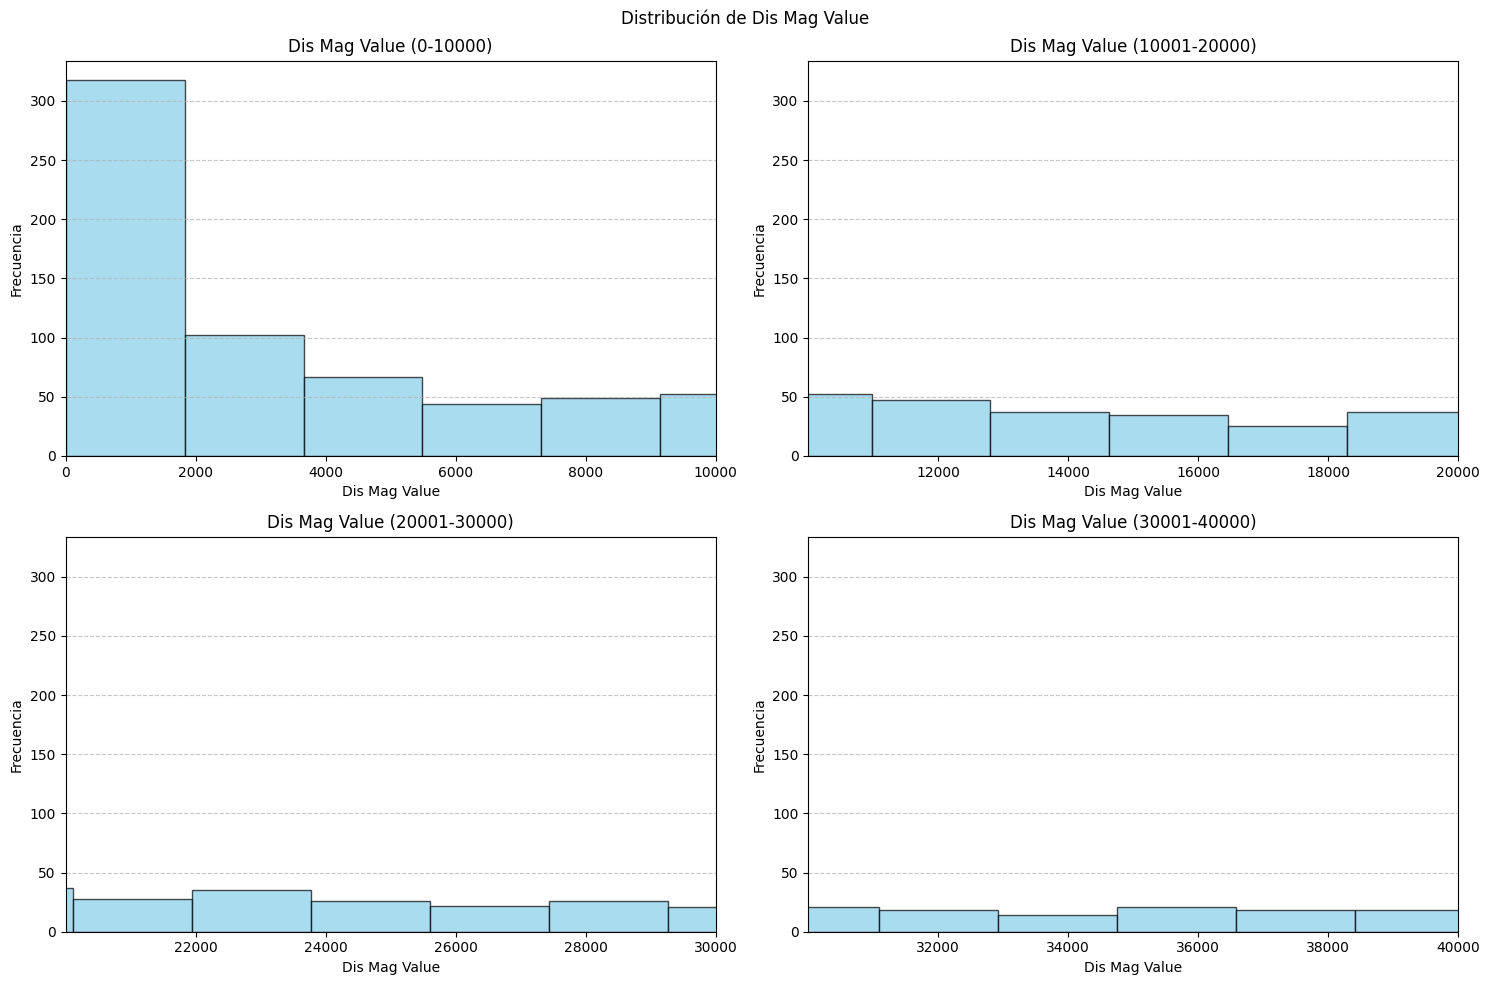

In [27]:
# Value counts y sort by index
value_counts_sorted = df_flood_filtered['Dis Mag Value'].value_counts().sort_index()

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Distribución de Dis Mag Value')

# Rangos de zoom para cada subplot
zoom_ranges = [(0, 10000), (10001, 20000), (20001, 30000), (30001, 40000), (40001, 50000), (50001, 60000)]

# Sector segmentado por zoom
for i, ax in enumerate(axes.flat):
    lower_limit, upper_limit = zoom_ranges[i]
    ax.hist(df_flood_filtered['Dis Mag Value'], bins=len(value_counts_sorted), edgecolor='black', color='skyblue', alpha=0.7)
    ax.set_xlabel('Dis Mag Value')
    ax.set_ylabel('Frecuencia')
    ax.set_xlim(lower_limit, upper_limit)
    ax.set_title(f'Dis Mag Value ({lower_limit}-{upper_limit})')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Función para crear columna categórica de nivel de impacto: Flood Type

Esta función sirve para asignar las etiquetas de clasificación Low, Moderate, High y Very High a partir de los umbrales establecidos a Dis Mag Value a partir de percentiles y considerando valores de impacto de Muertes, Afectados y Daños.

In [28]:
# Función previa que no considera valores nulos
def assign_flood_type(row):
    if row['Dis Mag Value'] < type1_threshold and row['Total Deaths'] < 100 and row['Total Affected'] < 10000 and row['Total Damages Adj'] < 1000000:
        return 'Low' # 1
    elif row['Dis Mag Value'] < type2_threshold and row['Total Deaths'] < 500 and row['Total Affected'] < 100000 and row['Total Damages Adj'] < 10000000:
        return 'Moderate' # 2
    elif row['Dis Mag Value'] < type3_threshold and row['Total Deaths'] < 1000 and row['Total Affected'] < 500000 and row['Total Damages Adj'] < 100000000:
        return 'High' # 3
    else:
        return 'Very High' # 4

In [29]:
df_flood_filtered['Flood Type'] = df_flood_filtered.apply(assign_flood_type, axis=1)
df_flood_filtered.head(10)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_760\1382504434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood_filtered['Flood Type'] = df_flood_filtered.apply(assign_flood_type, axis=1)


,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Flood Type
39,Flood,Riverine flood,China,Eastern Asia,Asia,Guangzhou,NaN,NaN,3000,Km2,1915,0,0,1915,0,0,0,3000000,0,Very High
123,Flood,Unknown,China,Eastern Asia,Asia,NaN,NaN,NaN,150000,Km2,1935,0,0,1935,0,0,142000,10030000,0,Very High
630,Flood,Unknown,Algeria,Northern Africa,Africa,"Northeast, Tlemcen",NaN,NaN,770,Km2,1973,3,0,1973,3,0,21,146000,65913,High
632,Flood,Unknown,Ecuador,South America,Americas,NaN,NaN,NaN,15000,Km2,1973,2,0,1973,2,0,0,30000,0,Moderate
782,Flood,Unknown,Ethiopia,Eastern Africa,Africa,Awash River Valley,NaN,NaN,18,Km2,1977,11,0,1977,11,0,7,16000,0,Moderate
1556,Flood,Unknown,India,Southern Asia,Asia,"Brahmaputra, Dhemaji, North Lakhimpur, Jorhat,...",NaN,NaN,2600,Km2,1971,6,0,1971,6,0,0,130000,0,High
1830,Flood,Unknown,Mozambique,Eastern Africa,Africa,Zambesi valley,NaN,NaN,615,Km2,1978,3,0,1978,3,0,40,200000,282635,High
1983,Flood,Unknown,Saint Vincent and the Grenadines,Caribbean,Americas,NaN,NaN,NaN,140,Km2,1977,10,18,1977,10,18,0,0,0,Low
2061,Flood,Riverine flood,China,Eastern Asia,Asia,"Hubei province, West Shangai",NaN,NaN,12140,Km2,1980,9,2,1980,9,2,0,0,0,Moderate
2128,Flood,Unknown,Guinea,Western Africa,Africa,"Niany, Tieney, Sirakoro, Balandougoubal, Dougo...",NaN,NaN,25,Km2,1981,9,0,1981,9,0,0,5000,0,Low


In [30]:
df_flood_filtered.shape

(1777, 20)

In [31]:
df_flood_filtered.columns

Index(['Disaster Type', 'Disaster Subtype', 'Country', 'Region', 'Continent',
       'Location', 'Origin', 'Associated Dis', 'Dis Mag Value',
       'Dis Mag Scale', 'Start Year', 'Start Month', 'Start Day', 'End Year',
       'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj', 'Flood Type'],
      dtype='object')

In [32]:
# Check the length of the DataFrame
num_rows_flood = df_flood_filtered.shape[0]
print("Number of rows in df_flood:", num_rows_flood)

# Check the index of the DataFrame
index_flood = df_flood_filtered.index
print("Index of df_flood:", index_flood)


Number of rows in df_flood: 1777
Index of df_flood: Int64Index([   39,   123,   630,   632,   782,  1556,  1830,  1983,  2061,
             2128,
            ...
            15929, 15931, 15944, 15965, 15977, 15989, 15994, 16021, 16037,
            16089],
           dtype='int64', length=1777)


### Codificación categórica a numérica

OrdinalEncoder para convertir variables categóricas Flood Type a numéricas 1, 2, 3 y 4

Se utiliza OrdinalEncoder para codificar la variable de salida porque:
1. La variable categórica Flood Type tiene una relación ordinal entre categorías y se les asigna explícitamente a valores numéricos significativos en función de su orden.
2. Permite especificar el orden de las categorías de forma explícita, lo que garantiza la asignación correcta de categorías a valores numéricos.
3. OrdinalEncoder es adecuado para variables categóricas ordinales donde el orden importa y los valores numéricos representan una clasificación o escala significativa.

In [33]:
# OrdinalEncoder requiere 2D array, reshape de 'Flood Type'
floodtype_to_encode = df_flood_filtered['Flood Type'].values.reshape(-1, 1)

# Definir el orden de las categorías (de más bajo a más alto)
ordered_categories = ['Low', 'Moderate', 'High', 'Very High']

# Crear instancia de OrdinalEncoder con el orden especificado
encoder = OrdinalEncoder(categories=[ordered_categories])

# Fit y transform de la columna 'Flood Type' para obtener ranking numérico
df_flood_filtered['Destruction Level'] = encoder.fit_transform(floodtype_to_encode) + 1

# Copiar filtered a df_flood_encoded DataFrame con la nueva columna 'Destruction Level' codificada
df_flood_encoded = df_flood_filtered.copy()

df_flood_encoded.head(10)


C:\Users\AleEng\AppData\Local\Temp\ipykernel_760\187363667.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood_filtered['Destruction Level'] = encoder.fit_transform(floodtype_to_encode) + 1


,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Flood Type,Destruction Level
39,Flood,Riverine flood,China,Eastern Asia,Asia,Guangzhou,NaN,NaN,3000,Km2,1915,0,0,1915,0,0,0,3000000,0,Very High,4.0
123,Flood,Unknown,China,Eastern Asia,Asia,NaN,NaN,NaN,150000,Km2,1935,0,0,1935,0,0,142000,10030000,0,Very High,4.0
630,Flood,Unknown,Algeria,Northern Africa,Africa,"Northeast, Tlemcen",NaN,NaN,770,Km2,1973,3,0,1973,3,0,21,146000,65913,High,3.0
632,Flood,Unknown,Ecuador,South America,Americas,NaN,NaN,NaN,15000,Km2,1973,2,0,1973,2,0,0,30000,0,Moderate,2.0
782,Flood,Unknown,Ethiopia,Eastern Africa,Africa,Awash River Valley,NaN,NaN,18,Km2,1977,11,0,1977,11,0,7,16000,0,Moderate,2.0
1556,Flood,Unknown,India,Southern Asia,Asia,"Brahmaputra, Dhemaji, North Lakhimpur, Jorhat,...",NaN,NaN,2600,Km2,1971,6,0,1971,6,0,0,130000,0,High,3.0
1830,Flood,Unknown,Mozambique,Eastern Africa,Africa,Zambesi valley,NaN,NaN,615,Km2,1978,3,0,1978,3,0,40,200000,282635,High,3.0
1983,Flood,Unknown,Saint Vincent and the Grenadines,Caribbean,Americas,NaN,NaN,NaN,140,Km2,1977,10,18,1977,10,18,0,0,0,Low,1.0
2061,Flood,Riverine flood,China,Eastern Asia,Asia,"Hubei province, West Shangai",NaN,NaN,12140,Km2,1980,9,2,1980,9,2,0,0,0,Moderate,2.0
2128,Flood,Unknown,Guinea,Western Africa,Africa,"Niany, Tieney, Sirakoro, Balandougoubal, Dougo...",NaN,NaN,25,Km2,1981,9,0,1981,9,0,0,5000,0,Low,1.0


#### Convertir Flood Type a Destruction Level numérica con get_dummies

In [34]:
# # Obtener valores únicos en columna 'Flood Type'
# unique_flood_types = df_flood_encoded['Flood Type'].unique()

# # Definir un diccionario de mapeo para las categorías en 'Flood Type' a valores numéricos
# destruction_mapping = {'Low': 1, 'Moderate': 2, 'High': 3, 'Very High': 4}

# # Crear una nueva columna 'Destruction Level' mapeando las categorías 'Flood Type' a valores numéricos
# df_flood_encoded['Destruction Level'] = df_flood_encoded['Flood Type'].map(destruction_mapping)

# df_flood_encoded

#### Revisión df_flood_encoded

In [35]:
df_flood_encoded.shape

(1777, 21)

In [36]:
len(df_flood_encoded)

1777

In [37]:
df_flood_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1777 entries, 39 to 16089
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Disaster Type      1777 non-null   object 
 1   Disaster Subtype   1777 non-null   object 
 2   Country            1777 non-null   object 
 3   Region             1777 non-null   object 
 4   Continent          1777 non-null   object 
 5   Location           1763 non-null   object 
 6   Origin             1513 non-null   object 
 7   Associated Dis     514 non-null    object 
 8   Dis Mag Value      1777 non-null   int64  
 9   Dis Mag Scale      1777 non-null   object 
 10  Start Year         1777 non-null   int64  
 11  Start Month        1777 non-null   int64  
 12  Start Day          1777 non-null   int64  
 13  End Year           1777 non-null   int64  
 14  End Month          1777 non-null   int64  
 15  End Day            1777 non-null   int64  
 16  Total Deaths       177

In [38]:
df_flood_encoded.columns

Index(['Disaster Type', 'Disaster Subtype', 'Country', 'Region', 'Continent',
       'Location', 'Origin', 'Associated Dis', 'Dis Mag Value',
       'Dis Mag Scale', 'Start Year', 'Start Month', 'Start Day', 'End Year',
       'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj', 'Flood Type', 'Destruction Level'],
      dtype='object')

In [39]:
df_flood_encoded['Destruction Level']

39       4.0
123      4.0
630      3.0
632      2.0
782      2.0
1556     3.0
1830     3.0
1983     1.0
2061     2.0
2128     1.0
2286     1.0
2314     4.0
2315     3.0
2319     2.0
2325     3.0
2329     3.0
2331     3.0
2333     4.0
2343     4.0
2350     4.0
2351     2.0
2353     4.0
2363     2.0
2365     4.0
2370     4.0
2388     4.0
2395     3.0
2403     3.0
2424     4.0
2459     4.0
2466     2.0
2483     3.0
2543     2.0
2546     1.0
2550     4.0
2569     2.0
2570     4.0
2582     3.0
2589     2.0
2605     2.0
2700     2.0
2767     2.0
3047     3.0
3050     3.0
3080     2.0
3081     3.0
3083     4.0
3084     4.0
3091     4.0
3092     4.0
3109     3.0
3112     2.0
3121     2.0
3141     2.0
3145     3.0
3159     4.0
3162     2.0
3193     3.0
3221     4.0
3231     3.0
3295     1.0
3373     4.0
3395     3.0
3446     2.0
3473     1.0
3537     4.0
3571     1.0
3574     2.0
3575     2.0
3580     2.0
3581     2.0
3582     2.0
3583     4.0
3584     3.0
3594     2.0
3595     4.0
3642     2.0

In [40]:
df_flood_encoded['Destruction Level'].isnull().sum()

0

#### Imputación de nulos en columna salida (y) Destruction Level con Simple Imputer

In [41]:
df_flood_encoded['Flood Type'].isna().sum()
df_flood_encoded['Flood Type'].unique()
len(df_flood_encoded['Flood Type'])

1777

### EDA Visualizaciones de 'Destruction Level' o Nivel de Destrucción

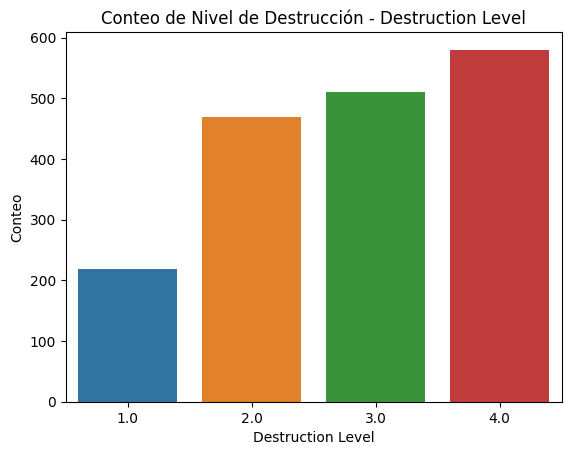

In [42]:
sns.countplot(data=df_flood_encoded, x='Destruction Level')
plt.title('Conteo de Nivel de Destrucción - Destruction Level')
plt.xlabel('Destruction Level')
plt.ylabel('Conteo')
plt.show()

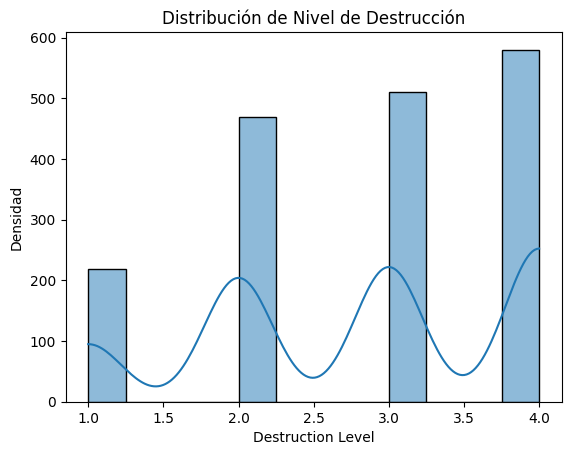

In [43]:
sns.histplot(data=df_flood_encoded, x='Destruction Level', kde=True)
plt.title(f'Distribución de Nivel de Destrucción')
plt.xlabel('Destruction Level')
plt.ylabel('Densidad')
plt.show()

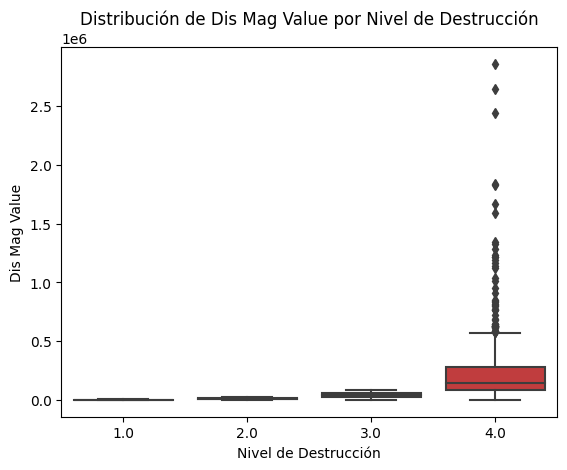

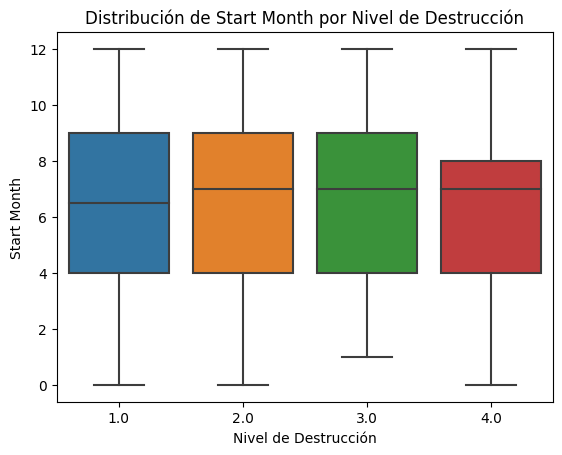

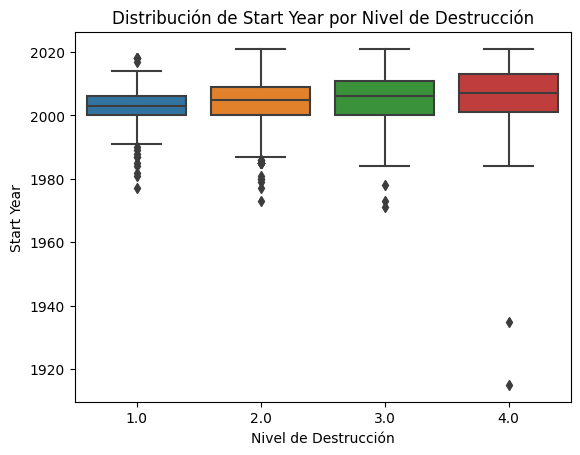

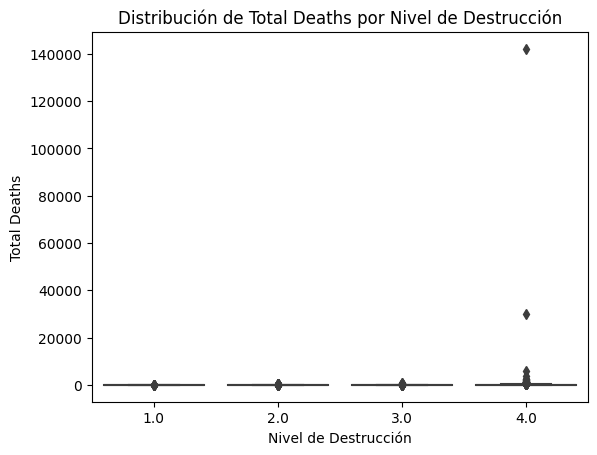

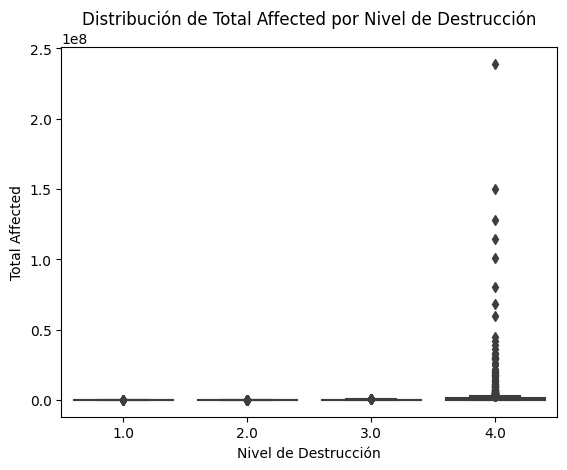

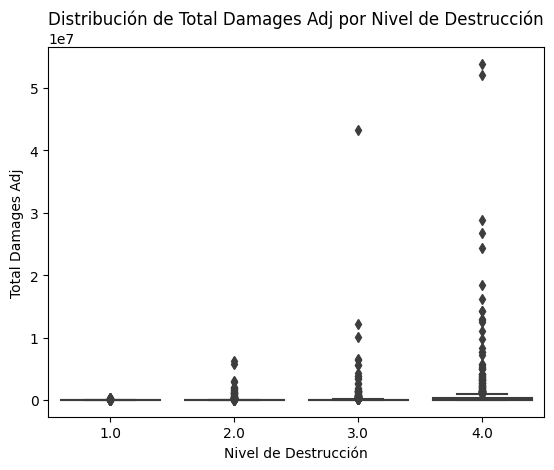

In [44]:
num_cols = ['Dis Mag Value', 'Start Month', 'Start Year', 'Total Deaths', 'Total Affected', 'Total Damages Adj']
for col in num_cols:
    sns.boxplot(data=df_flood_encoded, x='Destruction Level', y=col)
    plt.title(f'Distribución de {col} por Nivel de Destrucción')
    plt.xlabel('Nivel de Destrucción')
    plt.ylabel(col)
    plt.show()

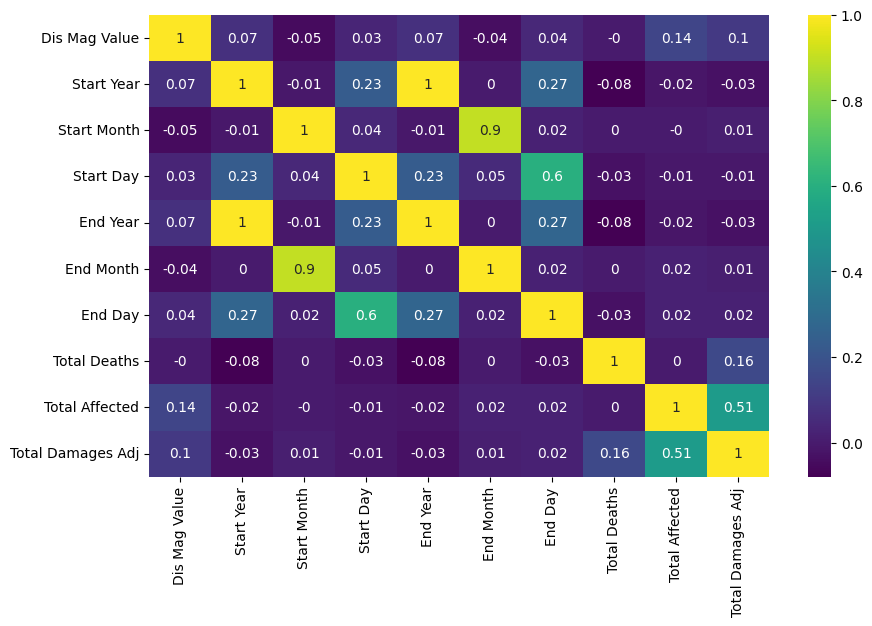

In [45]:
plt.figure(figsize=(10, 6))
df_corr = df_flood.corr(numeric_only=True).round(2)
sns.heatmap(df_corr, cmap='viridis', annot=True);

<Axes: xlabel='Dis Mag Value', ylabel='Destruction Level'>

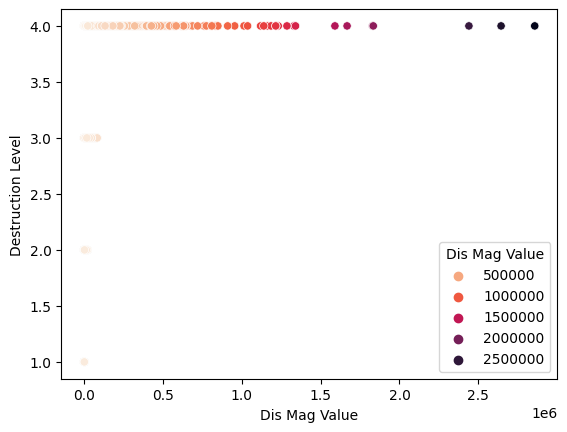

In [46]:
sns.scatterplot(data=df_flood_encoded, x='Dis Mag Value', y='Destruction Level', hue='Dis Mag Value', palette='rocket_r')

<Axes: xlabel='Start Month', ylabel='Destruction Level'>

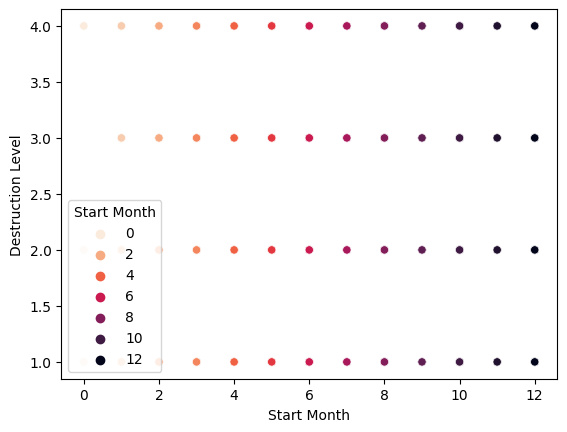

In [47]:
sns.scatterplot(data=df_flood_encoded, x='Start Month', y='Destruction Level', hue='Start Month', palette='rocket_r')

<Axes: xlabel='Start Year', ylabel='Destruction Level'>

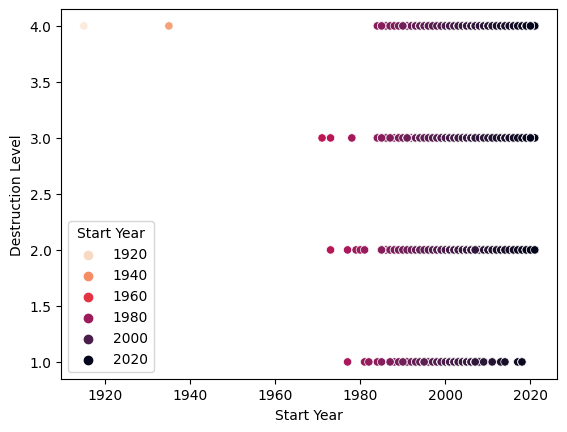

In [48]:
sns.scatterplot(data=df_flood_encoded, x='Start Year', y='Destruction Level', hue='Start Year', palette='rocket_r')

<Axes: xlabel='Total Deaths', ylabel='Destruction Level'>

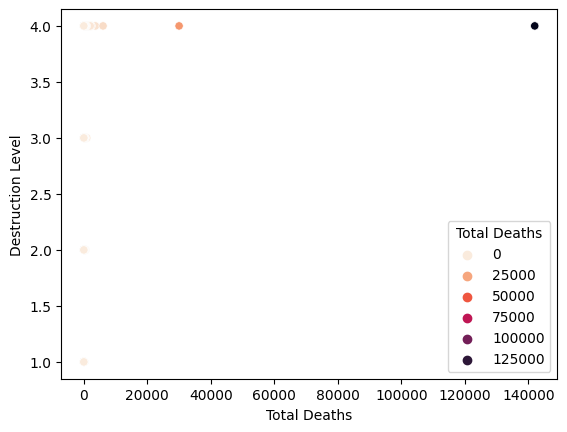

In [49]:
sns.scatterplot(data=df_flood_encoded, x='Total Deaths', y='Destruction Level', hue='Total Deaths', palette='rocket_r')

<Axes: xlabel='Total Affected', ylabel='Destruction Level'>

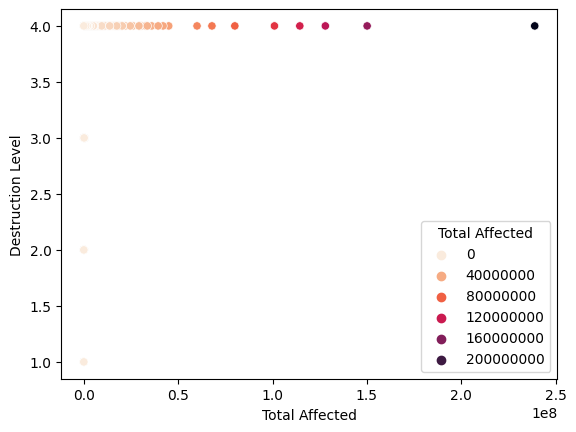

In [50]:
sns.scatterplot(data=df_flood_encoded, x='Total Affected', y='Destruction Level', hue='Total Affected', palette='rocket_r')

<Axes: xlabel='Total Damages Adj', ylabel='Destruction Level'>

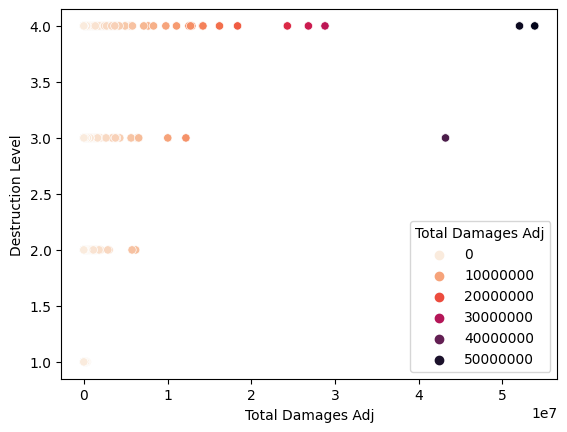

In [51]:
sns.scatterplot(data=df_flood_encoded, x='Total Damages Adj', y='Destruction Level', hue='Total Damages Adj', palette='rocket_r')

* La primera visualización muestra la relación entre 'Dis Mag Value' y 'Destruction Level'. Sugiere que existe una fuerte correlación entre estas dos variables, ya que el 'Nivel de destrucción' tiende a aumentar con un 'Valor de Magnitud de Desastre' más alto.
* La segunda visualización muestra la relación entre el 'Mes de inicio' y el 'Nivel de destrucción'. Indica que podría haber alguna variación en el 'Nivel de destrucción' entre diferentes meses, aunque el patrón no está explícitamente claro.
* La tercera visualización representa la relación entre el 'Año de inicio' y el 'Nivel de destrucción'. Sugiere que podría haber algunas tendencias o patrones en el 'Nivel de destrucción' a lo largo de los años, aunque una visión más específica requeriría un análisis más profundo, dado que influye la capacidad de recolección de datos por el incremento y mejora en conocimientos estadísticos e implementación de nuevas tecnologías.
* La cuarta visualización muestra la relación entre 'Muertes Totales' y 'Nivel de Destrucción'. Indica que un 'Total de muertes' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.
* La quinta visualización muestra la relación entre 'Total de afectados' y 'Nivel de destrucción'. Sugiere que un 'total afectado' más alto tiende a asociarse con un 'nivel de destrucción' más alto.
* La sexta visualización representa la relación entre 'Total Damages Adj' y 'Destruction Level'. Indica que un 'Ajuste total de daños' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.

### Pivot Tables

In [52]:
df_floodresult_pivot_table_min = pd.pivot_table(df_flood_encoded, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='min')
df_floodresult_pivot_table_min

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1.0,2,0,0,0
2.0,3,0,0,0
3.0,4,0,0,0
4.0,120,0,0,0


In [53]:
df_floodresult_pivot_table_max = pd.pivot_table(df_flood_encoded, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='max')
df_floodresult_pivot_table_max

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1.0,4170,9855,382046,98
2.0,24415,99185,6192575,498
3.0,84662,498924,43201120,921
4.0,2857000,238973000,53860097,142000


In [54]:
df_floodresult_pivot_table_sum = pd.pivot_table(df_flood_encoded, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='sum')
df_floodresult_pivot_table_sum

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1.0,278205,438092,3422569,2281
2.0,4659410,7489867,51888782,12958
3.0,19725722,45573302,156203475,16207
4.0,138932750,2019715249,546029546,252244


In [55]:
df_floodresult_pivot_table_mean = pd.pivot_table(df_flood_encoded, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='mean')
df_floodresult_pivot_table_mean

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1.0,1276.169725,2.009596e+03,15699.857798,10.463303
2.0,9934.776119,1.596987e+04,110637.061834,27.628998
3.0,38677.886275,8.935942e+04,306281.323529,31.778431
4.0,239539.224138,3.482268e+06,941430.251724,434.903448


In [56]:
df_floodresult_pivot_table_median = pd.pivot_table(df_flood_encoded, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='median')
df_floodresult_pivot_table_median

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1.0,920,1200,0,4
2.0,9280,6000,0,8
3.0,37895,25000,0,11
4.0,140000,119255,12581,27


## Preparar X y

In [57]:
X = df_flood_encoded.drop('Destruction Level', axis=1).select_dtypes(exclude=['object'])  # Excluir columnas categóricas
y = df_flood_encoded['Destruction Level'] # Quitar Destruction Level y poner los binarios de Flood Type

## train_test_split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"train: {X_train.shape}, {y_train.shape}")
print(f"test: {X_test.shape}, {y_test.shape}")

train: (1421, 10), (1421,)
test: (356, 10), (356,)


### SMOTE Balanceo de clases

In [59]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"original: {X_train.shape} {y_train.shape}")
print(f"resampled: {X_train_res.shape} {y_train_res.shape}")

# comprobar que se han balanceado las clases
y_train_res.value_counts()

original: (1421, 10) (1421,)
resampled: (1876, 10) (1876,)


4.0    469
3.0    469
1.0    469
2.0    469
Name: Destruction Level, dtype: int64

# Modelo

## Definir el Modelo

#### Pipeline columnas numéricas

In [60]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes usando most_frequent
    ('scaler', StandardScaler()),  # Escalar características numéricas
    ('classifier', RandomForestClassifier()) # Modelo elegido a partir de validación al ser el mejor del ranking
])

## Ejecución de pipeline

### Entrenar el modelo

In [61]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

#### Explicación de pipeline:
Incluye los siguientes pasos: SimpleImputer, StandardScaler y RandomForestClassifier.
* SimpleImputer para manejar los valores faltantes en los datos.
* StandardScaler para estandarizar las características numéricas, asegurando que tengan una media cero y una varianza unitaria.
* RandomForestClassifier es el modelo de clasificación elegido.

## Ejecución de pipeline

In [62]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Guardar pipeline

Se usa joblib para guardar modelos o pipelines.

Serializa un modelo o pipeline (objeto Python) a una secuencia de bytes que se almacenan en un archivo

* joblib.dump()
* joblib.load()

In [63]:
# pickle .pkl o .joblib
joblib.dump(pipeline, 'pipelineRFC_Flood_DestructionLvl.pkl') # más genérico
joblib.dump(pipeline, 'pipelineRFC_Flood_DestructionLvl.joblib') # más eficiente con muchos datos

['pipelineRFC_Flood_DestructionLvl.joblib']

## Cargar pipeline

In [64]:
pipeline = joblib.load('pipelineRFC_Flood_DestructionLvl.joblib')
pipeline.predict(X_test)[:10]

array([4., 3., 2., 4., 1., 4., 2., 3., 2., 4.])

# Predicción y_pred

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
y_pred.shape

(356,)

# Evaluar Modelo

## Evaluación de error del modelo con mae, rmse y r2

In [67]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Coefficient of Determination (R^2):", r2)

Mean Absolute Error (MAE): 0.019662921348314606
Root Mean Squared Error (RMSE): 0.14022453903762566
Coefficient of Determination (R^2): 0.9799786288735167


### Resultados de mae, rmse y r2
* Los valores varían cada vez que se vuelve a cargar el notebook

Mean Absolute Error (MAE): 0.019662921348314606
Root Mean Squared Error (RMSE): 0.14022453903762566
Coefficient of Determination (R^2): 0.9799786288735167

1. Error absoluto medio (MAE): 0,019662921348314606

El error absoluto medio mide la diferencia absoluta media entre los valores predichos y los valores objetivo reales.
En este caso, el valor MAE de aproximadamente 0,0197 indica que, en promedio, las predicciones del modelo se desvían de los verdaderos valores objetivo en alrededor de 0,0197 unidades. Los valores más bajos de MAE indican un mejor rendimiento, ya que las predicciones del modelo se acercan más a los valores reales.

2. Error cuadrático medio (RMSE): 0,14022453903762566

El error cuadrático medio de la raíz es otra métrica para evaluar la precisión del modelo al medir la raíz cuadrada del promedio de las diferencias al cuadrado entre los valores predichos y reales.
En este caso, el valor RMSE de aproximadamente 0,1402 indica que, en promedio, las predicciones del modelo se desvían de los verdaderos valores objetivo en alrededor de 0,1402 unidades. Al igual que MAE, los valores más bajos de RMSE indican un mejor rendimiento.

3. Coeficiente de Determinación (R^2): 0.9799786288735167

El coeficiente de determinación, a menudo denominado R^2, mide la proporción de varianza en la variable de destino que es predecible a partir de las variables independientes (características) utilizadas en el modelo.
R^2 varía de 0 a 1, donde 1 indica que el modelo se ajusta perfectamente a los datos y 0 indica que el modelo no funciona mejor que la media de los valores objetivo.
En este caso, el valor de R^2 de aproximadamente 0,98 es bastante alto, lo que indica que el modelo explica alrededor del 98 % de la varianza de la variable objetivo en función de las funciones utilizadas. Esto sugiere que las predicciones del modelo están muy cerca de los valores objetivo reales y que se ajusta bien a los datos.

En resumen, el modelo parece funcionar muy bien según estas métricas:

Los valores bajos de MAE y RMSE indican que las predicciones del modelo están cerca de los valores objetivo reales, con solo pequeñas diferencias promedio.
El valor alto de R^2 sugiere que el modelo explica una parte significativa de la varianza en la variable objetivo, lo que indica un buen ajuste a los datos.

### Reporte de clasificación

El informe de clasificación proporciona métricas de evaluación para el modelo RandomForestClassifier.
La precisión, el recuerdo (recall) y la puntuación F1 (f1-score) se informan para cada clase (1, 2, 3, 4), junto con el soporte (número de muestras) para cada clase.
También se informa la precisión del modelo: 1, lo que indica la corrección general de las predicciones.
Las métricas de macro avg o macropromedio y weighted avg o promedio ponderado proporcionan medidas de rendimiento agregadas en todas las clases.

In [75]:
# Evaluar desempeño del dataset
print("Reporte de clasificación:")
print(classification_report(y_pred, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        33
         2.0       1.00      1.00      1.00       114
         3.0       1.00      1.00      1.00        99
         4.0       1.00      1.00      1.00       110

    accuracy                           1.00       356
   macro avg       1.00      1.00      1.00       356
weighted avg       1.00      1.00      1.00       356



### cross_validate

In [77]:
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'], return_train_score=True)
cv_results

{'fit_time': array([0.16708708, 0.17334127, 0.15509701, 0.15601516, 0.17177916]),
 'score_time': array([0.00690365, 0.00699687, 0.00599647, 0.00735688, 0.00790429]),
 'test_neg_mean_absolute_error': array([-0.01403509, -0.01056338, -0.01408451, -0.01408451, -0.01056338]),
 'train_neg_mean_absolute_error': array([-0., -0., -0., -0., -0.]),
 'test_neg_mean_squared_error': array([-0.01403509, -0.01056338, -0.01408451, -0.01408451, -0.01056338]),
 'train_neg_mean_squared_error': array([-0., -0., -0., -0., -0.]),
 'test_r2': array([0.98674942, 0.99003975, 0.98671966, 0.9868628 , 0.99010258]),
 'train_r2': array([1., 1., 1., 1., 1.])}

#### Interpretación de resultados de cross_validate:

* fit_time: esta matriz contiene el tiempo necesario para ajustar el estimador (modelo) en cada pliegue de la validación cruzada. Los valores están en segundos.

* score_time: esta matriz contiene el tiempo necesario para puntuar (evaluar) el estimador en cada pliegue de la validación cruzada. Los valores están en segundos.

* test_neg_mean_absolute_error: esta matriz contiene el error absoluto medio (MAE) para cada pliegue de prueba. MAE mide la diferencia absoluta promedio entre los valores previstos y reales. Los valores son negativos porque scikit-learn multiplica la métrica por -1 para convertir las puntuaciones en problemas de maximización. Por lo tanto, los valores negativos más altos indican un mejor rendimiento.

* train_neg_mean_absolute_error: Esta matriz contiene el MAE para cada pliegue del tren. Sin embargo, los valores son todos cero. Esto podría indicar que la canalización no devolvió ningún error de entrenamiento durante la validación cruzada, posiblemente debido a un ajuste perfecto o a un problema con los datos o la canalización.

* test_neg_mean_squared_error: esta matriz contiene el error cuadrático medio (MSE) para cada pliegue de prueba. MSE mide la diferencia cuadrática promedio entre los valores predichos y reales. Los valores son negativos por la misma razón que el MAE.

* train_neg_mean_squared_error: esta matriz contiene el MSE para cada pliegue del tren. Al igual que MAE, todos los valores son cero, lo que sugiere que la canalización no devolvió ningún error de entrenamiento durante la validación cruzada.

* test_r2: esta matriz contiene el R-cuadrado (coeficiente de determinación) para cada pliegue de prueba. R-cuadrado mide qué tan bien los valores pronosticados coinciden con la varianza de los valores reales. Va de 0 a 1, donde 1 indica un ajuste perfecto. Los valores aquí están cerca de 1, lo que significa que el modelo se ha desempeñado muy bien en los datos de prueba.

* train_r2: Esta matriz contiene el R-cuadrado para cada pliegue del tren. Al igual que con los otros puntajes de entrenamiento, todos los valores son cero, lo que indica que no hay errores de entrenamiento durante la validación cruzada.

En general, el modelo parece estar funcionando excepcionalmente bien, dados los altos valores de R-cuadrado y los errores medios absolutos y medios cuadráticos bajos. Sin embargo, los errores de entrenamiento cero son inusuales y pueden indicar un problema potencial con el pipeline o los datos.

# Tests de predicciones X_destruction

* Test A: controlado, valores acordes a umbrales
* Test B: outliers, algunos valores fuera del rango típico
* Test C: low, valores con tendencia a low para probar Destruction Level 1

Se intentaron:
* Test D: reduced_magimpact, columna de magnitud + temporales
* Test D: reduced_time, solo columnas de tiempo

## Predicción X_destruction_controlled
2024-2027, máximo de columnas entrada X, valores controlados bajo umbrales

In [68]:
X_destruction_controlled= pd.DataFrame({'Dis Mag Value': [10, 4500, 26000, 90000],
                             'Start Year': [2024, 2025, 2026, 2027],
                             'Start Month': [1, 5, 8, 12],
                             'Start Day': [6, 16, 24, 30],
                             'End Year': [2024, 2025, 2026, 2027],
                             'End Month': [1, 5, 9, 1],
                             'End Day': [8, 21, 4, 28],
                             'Total Deaths': [70, 250, 800, 10000],
                             'Total Affected': [5000, 25000, 300000, 1000000],
                             'Total Damages Adj': [200000, 5000000, 12000000, 101000000]
                             })

X_destruction_controlled['Destruction Level'] = pipeline.predict(X_destruction_controlled)
X_destruction_controlled

,Dis Mag Value,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Destruction Level
0,10,2024,1,6,2024,1,8,70,5000,200000,2.0
1,4500,2025,5,16,2025,5,21,250,25000,5000000,3.0
2,26000,2026,8,24,2026,9,4,800,300000,12000000,3.0
3,90000,2027,12,30,2027,1,28,10000,1000000,101000000,4.0


### Predicción X_destruction_outliers
2024-2027, máximo de columnas entrada X, valores con outliers en últimas filas

In [69]:
X_destruction_outliers = pd.DataFrame({'Dis Mag Value': [10, 4500, 26000, 2], # se cambió solo 90000 a 2
                             'Start Year': [2024, 2025, 2026, 2027],
                             'Start Month': [1, 5, 8, 12],
                             'Start Day': [6, 16, 24, 30],
                             'End Year': [2024, 2025, 2026, 2027],
                             'End Month': [1, 5, 9, 1],
                             'End Day': [8, 21, 4, 28],
                             'Total Deaths': [70, 250, 800, 10], # se quitaron 0s
                             'Total Affected': [5000, 25000, 300000, 10], # se quitaron 0s
                             'Total Damages Adj': [200000, 5000000, 12000000, 10] # se quitaron 0s
                             })

X_destruction_outliers['Destruction Level'] = pipeline.predict(X_destruction_outliers)
X_destruction_outliers

,Dis Mag Value,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Destruction Level
0,10,2024,1,6,2024,1,8,70,5000,200000,2.0
1,4500,2025,5,16,2025,5,21,250,25000,5000000,3.0
2,26000,2026,8,24,2026,9,4,800,300000,12000000,3.0
3,2,2027,12,30,2027,1,28,10,10,10,1.0


### Predicción X_destruction_low
2024-2027, máximo de columnas entrada X, valores reducidos para probar Low o 1

In [70]:
X_destruction_low = pd.DataFrame({
    'Dis Mag Value': [5, 3000, 1500, 1],  # Valores 'Dis Mag Value' reducidos
    'Start Year': [2024, 2025, 2026, 2027],
    'Start Month': [1, 5, 8, 12],
    'Start Day': [6, 16, 24, 30],
    'End Year': [2024, 2025, 2026, 2027],
    'End Month': [1, 5, 9, 1],
    'End Day': [8, 21, 4, 28],
    'Total Deaths': [35, 150, 2, 5],  # Valores 'Total Deaths' reducidos
    'Total Affected': [2500, 12000, 8, 5],  # Valores 'Total Affected' reducidos
    'Total Damages Adj': [100000, 3000000, 6, 5]  # Valores 'Total Damages Adj' reducidos
})

X_destruction_low['Destruction Level'] = pipeline.predict(X_destruction_low)
X_destruction_low

,Dis Mag Value,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Destruction Level
0,5,2024,1,6,2024,1,8,35,2500,100000,2.0
1,3000,2025,5,16,2025,5,21,150,12000,3000000,2.0
2,1500,2026,8,24,2026,9,4,2,8,6,1.0
3,1,2027,12,30,2027,1,28,5,5,5,1.0


Realizamos un test A y B, el primero con valores acordes a los umbrales y el segundo con algunos valores outliers en las últimas filas de entradas seleccionadas para controlar si la predicción es acertada o no.

In [71]:
# pipeline.fit(X_destruction_controlled[['Dis Mag Value']], y_destruction_controlled)
# pipeline.fit(X_destruction_outliers[['Dis Mag Value']], y_destruction_outliers)

# Prueba introduciendo valores
X_destruction_controlled['Destruction Level'] = [2, 3, 3, 4]
X_destruction_outliers['Destruction Level'] = [2, 3, 3, 1]
X_destruction_low['Destruction Level'] = [1, 3, 4, 1]

# Separar features y variables y target para los distintos datasets de testeo
X_controlled = X_destruction_controlled[['Dis Mag Value']]
y_controlled = X_destruction_controlled['Destruction Level']

X_outliers = X_destruction_outliers[['Dis Mag Value']]
y_outliers = X_destruction_outliers['Destruction Level']

X_low = X_destruction_low[['Dis Mag Value']]
y_low = X_destruction_low['Destruction Level']

pipeline = RandomForestClassifier()
pipeline.fit(X_controlled, y_controlled)

# Predecir sobre X controlada
y_controlled_pred = pipeline.predict(X_controlled)

# Predecir sobre X con outliers
y_outliers_pred = pipeline.predict(X_outliers)

# Predecir sobre valores reducidos (tendencia a low)
y_low_pred = pipeline.predict(X_low)

Comparar test A: y_controlled_pred con y_controlled y  test B: y_outliers_pred con y_outliers y test C: y_controlled_low con y_low para evaluar el rendimiento de las predicciones en los conjuntos de datos controlados y de valores atípicos.

# Validaciones de Tests A, B y C

## Reportes de Clasificación para Tests A, B y C

El informe de clasificación proporciona un resumen detallado del rendimiento del modelo en cada clase (en este caso, cada 'Destruction Level') para los conjuntos de datos controlados y atípicos. El informe incluye métricas como precisión, recall y f1-score, que son medidas de la precisión y la integridad del modelo para cada clase.

In [72]:
# Evaluar desempeño del dataset controlado
print("Dataset Controlado o Test A:")
print(classification_report(y_controlled, y_controlled_pred))

# Evaluar desempeño del dataset con outliers
print("Outliers Dataset o Test B:")
print(classification_report(y_outliers, y_outliers_pred))

# Evaluar desempeño del dataset con valores bajos
print("Low Dataset o Test C:")
print(classification_report(y_low, y_low_pred))

Dataset Controlado o Test A:
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Outliers Dataset o Test B:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         2

    accuracy                           0.75         4
   macro avg       0.50      0.67      0.56         4
weighted avg       0.62      0.75      0.67         4

Low Dataset o Test C:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        

c:\Users\AleEng\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AleEng\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AleEng\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

### Interpretación de resultados de Tests A, B y C:

* Precisión: la prueba A logró una puntuación de precisión perfecta de 1,00 para todas las clases (2, 3 y 4). La prueba B logró diferentes puntajes de precisión para cada clase, con 0,00 para la clase 1, 0,50 para la clase 2 y 1,00 para la clase 3. La prueba C logró una precisión de 0,00 para las clases 1 y 2, y 1,00 para la clase 3.

* Recall: Tanto la Prueba A como la Prueba B lograron puntajes perfectos de recuerdo de 1.00 para todas las clases. La prueba C logró un recuerdo de 0,00 para las clases 1 y 2, y de 1,00 para la clase 3.

* f1-score: la prueba A logró una puntuación F1 perfecta de 1,00 para todas las clases. La prueba B logró una puntuación F1 más baja para la clase 2 (0,67) debido a una menor precisión. La prueba C logró una puntuación F1 de 0,00 para las clases 1 y 2, y de 1,00 para la clase 3.

* Soporte: el soporte indica el número de instancias para cada clase en los conjuntos de datos de prueba. La prueba B tiene el soporte más pequeño para la clase 2, con solo una instancia.

* Accuracy: la prueba A logró una precisión perfecta de 1,00, lo que significa que todas las instancias se clasificaron correctamente. La prueba B logró una precisión de 0,75, lo que indica que el 75 % de las instancias se clasificaron correctamente. La prueba C logró una precisión de 0,25, lo que significa que solo el 25 % de las instancias se clasificaron correctamente.

* Macro Promedio: El promedio macro de precisión, recuperación y puntaje F1 en las tres pruebas es el mismo, con un valor de 0.25. Esto se calcula como el promedio de las puntuaciones de todas las clases, independientemente del desequilibrio de clases.

* Promedio ponderado: el promedio ponderado de precisión, recuperación y puntaje F1 en las tres pruebas también es el mismo, con un valor de 0.25. Esto se calcula como el promedio de los puntajes, ponderado por el apoyo de cada clase, y está influenciado por los desequilibrios de clase.

### Conclusión de reportes de clasificación a pruebas A, B y C

La prueba A logró un rendimiento perfecto con una precisión de 1,00, lo que indica la capacidad del modelo para clasificar instancias correctamente para todas las clases. La prueba B también mostró un buen rendimiento con una precisión de 0,75, pero con una puntuación F1 más baja para la clase 2 debido a una precisión más baja. La prueba C, por otro lado, tuvo un rendimiento deficiente con una precisión de 0.25, baja precisión y recuperación para la mayoría de las clases, y una puntuación F1 general de 0.

Conjunto de datos controlado (Test A):

El modelo logró una precisión y exactitud perfectas en este conjunto de datos, lo que sugiere que se desempeña extremadamente bien en las características específicas definidas en el conjunto de datos controlado.
Sin embargo, la preocupación aquí es que el modelo podría estar sobreajustado a los umbrales y características específicos utilizados para crear la clasificación del tipo de inundación. El sobreajuste ocurre cuando un modelo funciona muy bien con los datos de entrenamiento, pero no logra generalizar bien con los datos no vistos. En este caso, el modelo puede haber memorizado los umbrales y las características utilizadas para crear la clasificación, lo que lleva a un rendimiento perfecto en este conjunto de datos específico, pero un rendimiento potencialmente deficiente en datos nuevos e invisibles.

Conjunto de datos de valores atípicos (Test B):

El rendimiento del modelo en el conjunto de datos de valores atípicos no es tan bueno como el conjunto de datos controlado, pero aun así logra una exactitud y precisión decentes para algunas clases.
La caída en el rendimiento al aplicar valores atípicos a las columnas de impacto y ajustar el valor Dis Mag indica que es posible que el modelo no maneje bien los puntos de datos extremos o fuera de distribución, lo cual es bastante común en los desastres, debido a su variabilidad e impredictibilidad. Esto puede deberse a la incapacidad del modelo para generalizar variaciones invisibles en los datos, ya que es posible que los valores atípicos no se hayan representado bien durante el entrenamiento.

Conjunto de datos bajo (Test C):

Los valores bajos en el Destruction Level 1 dieron como resultado un rendimiento deficiente, con baja precisión y precisión.
La sugerencia de que los datos pueden faltar o estar menos completos para las clasificaciones más bajas es plausible. Si el modelo no estuvo expuesto a suficientes datos con instancias de nivel de destrucción 1 durante el entrenamiento, es posible que tenga dificultades para hacer predicciones precisas para estas instancias durante las pruebas.

## Tests con pruebas reduciendo columnas X

### Predicción X_destruction_reduced_magimpact
2024-2027, 4 cols para entrada X: magnitud e impacto, valores copiados de datos controlados

In [73]:
# X_destruction_reduced_magimpact = pd.DataFrame({
#     'Dis Mag Value': [5, 30000, 150000, 2500005],  # Valores 'Dis Mag Value' de low a high
#     'Total Deaths': [70, 250, 800, 10000],
#     'Total Affected': [5000, 25000, 300000, 1000000],
#     'Total Damages Adj': [200000, 5000000, 12000000, 101000000]
# })

# X_destruction_reduced_magimpact['Destruction Level'] = pipeline.predict(X_destruction_reduced_magimpact)
# X_destruction_reduced_magimpact

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Total Affected
- Total Damages Adj
- Total Deaths


### Predicción X_destruction_reduced_magimpact
2024-2027, 4 cols para entrada X: magnitud e impacto, valores copiados de datos controlados

In [ ]:
# X_destruction_reduced_time = pd.DataFrame({
#     'Start Year': [2024, 2025, 2026, 2027],
#     'Start Month': [2, 6, 9, 11],
#     'Start Day': [6, 16, 24, 10],
#     'End Year': [2024, 2025, 2026, 2027],
#     'End Month': [2, 6, 10, 12],
#     'End Day': [8, 21, 8, 28]
# })

# X_destruction_reduced_time['Destruction Level'] = pipeline.predict(X_destruction_reduced_time)
# X_destruction_reduced_time

Se realizaron intentos de pruebas reduciendo columnas de entrada, sin embargo, no son aceptadas y habría que realizar otro pipeline para entrenar de nuevo al modelo con menos información. Sería conveniente para probar si, escondiendo información se puede prevenir overfitting y realizar otras comprobaciones.

# Conclusiones del modelo RandomForestClassifier para predecir Destruction Level

Las métricas de validación del modelo general y el Test A, controlado, sugieren colectivamente que el modelo tiene un alto nivel de precisión y capacidad predictiva para el conjunto de datos dado. Sin embargo, en el test B con outliers falla en predecir las clases bajas, debido posiblemente a una falta de datos en el dataset. Es precisamente en la clasificación low, detectada y probada donde se observan las mayores deficiencias, desempeñándose pobremente en Test C con valores bajos. 

siempre es una buena práctica realizar una validación cruzada del modelo y evaluar su rendimiento en datos ocultos para garantizar su capacidad de generalización.

### Conclusión del reporte de clasificación de Tests A, B y C

Interpretación comparada de tests A, B y C:
El modelo funciona extremadamente bien en el conjunto de datos controlado, logrando una precisión, recall y f1-score perfectos para todas las clases. Esto indica que el modelo predijo con precisión todas las instancias de cada clase y no hubo predicciones falsas positivas o falsas negativas.

Por otro lado, el rendimiento del modelo en el conjunto de datos de valores atípicos no es tan sólido. Predijo correctamente todas las instancias de la clase 3 (alta precisión, recall y f1-score), pero tuvo problemas con la clase 1 y no pudo hacer predicciones correctas. La puntuación F1 para la clase 2 es moderada, lo que indica un compromiso entre precisión y recuperación. En general, el modelo logró una precisión del 75 % en el conjunto de datos de valores atípicos.

Es importante tener en cuenta que el tamaño pequeño del conjunto de datos puede afectar las métricas de evaluación. En escenarios del mundo real, es común tener conjuntos de datos desequilibrados, que pueden requerir técnicas adicionales como el aumento de datos o la ponderación de clases para abordar el desequilibrio y mejorar el rendimiento del modelo.

En resumen, el modelo funciona excepcionalmente bien en el conjunto de datos controlado, pero muestra margen de mejora en el conjunto de datos de valores atípicos, especialmente para la clase 1. Es posible que se necesiten datos adicionales y ajustes del modelo para mejorar su rendimiento en el manejo de valores atípicos.

# Recomendaciones

Las métricas sugieren colectivamente que el modelo tiene un alto nivel de precisión y capacidad predictiva para el conjunto de datos dado. Sin embargo, siempre es una buena práctica realizar una validación cruzada del modelo y de los diferentes tests, así como evaluar su rendimiento en datos ocultos para garantizar su capacidad de generalización.

Respecto a los rultados de classification report y cross_validate:
Es esencial investigar más a fondo el preprocesado, pipeline y sus componentes para garantizar que todo funcione según lo previsto. Además de considerar diferentes métricas de rendimiento y examinar las curvas de aprendizaje para obtener una visión completa del rendimiento del modelo.